# I2MC Example
-----

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import import_funcs as imp
import I2MC
import matplotlib.pyplot as plt
import time
start = time.time()

## Options

In [2]:
log_level    = 1    # 0: no output, 1: output from this script only, 2: provide some output on command line regarding I2MC internal progress
do_plot_data = True # if set to True, plot of fixation detection for each trial will be saved as png-file in output folder.
# the figures works best for short trials (up to around 20 seconds)

In [3]:
opt = {}
# General variables for eye-tracking data
opt['xres']         = 1920.0                # maximum value of horizontal resolution in pixels
opt['yres']         = 1080.0                # maximum value of vertical resolution in pixels
opt['missingx']     = -opt['xres']          # missing value for horizontal position in eye-tracking data (example data uses -xres). used throughout the algorithm as signal for data loss
opt['missingy']     = -opt['yres']          # missing value for vertical position in eye-tracking data (example data uses -yres). used throughout algorithm as signal for data loss
opt['freq']         = 300.0                 # sampling frequency of data (check that this value matches with values actually obtained from measurement!)

# Variables for the calculation of angular measures
# These values are used to calculate noise measures (RMS and BCEA) of
# fixations. The may be left as is, but don't use the noise measures then.
# If either or both are empty, the noise measures are provided in pixels
# instead of degrees.
opt['scrSz']        = [50.9174, 28.6411]    # screen size in cm
opt['disttoscreen'] = 65.0                  # distance to screen in cm.

### Optional Options

In [4]:
# The settings below may be used to adopt the default settings of the
# algorithm. Do this only if you know what you're doing.

# # STEFFEN INTERPOLATION
opt['windowtimeInterp']     = 0.1                           # max duration (s) of missing values for interpolation to occur
opt['edgeSampInterp']       = 2                             # amount of data (number of samples) at edges needed for interpolation
opt['maxdisp']              = opt['xres']*0.2*np.sqrt(2)    # maximum displacement during missing for interpolation to be possible

# # K-MEANS CLUSTERING
opt['windowtime']           = 0.2                           # time window (s) over which to calculate 2-means clustering (choose value so that max. 1 saccade can occur)
opt['steptime']             = 0.02                          # time window shift (s) for each iteration. Use zero for sample by sample processing
opt['maxerrors']            = 100                           # maximum number of errors allowed in k-means clustering procedure before proceeding to next file
opt['downsamples']          = [2, 5, 10]
opt['downsampFilter']       = False                         # use chebychev filter when downsampling? Its what matlab's downsampling functions do, but could cause trouble (ringing) with the hard edges in eye-movement data
opt['chebyOrder']           = 8.                            # order of cheby1 Chebyshev downsampling filter, default is normally ok, as long as there are 25 or more samples in the window (you may have less if your data is of low sampling rate or your window is small)

# # FIXATION DETERMINATION
opt['cutoffstd']            = 2.0                           # number of standard deviations above mean k-means weights will be used as fixation cutoff
opt['onoffsetThresh']       = 3.0                           # number of MAD away from median fixation duration. Will be used to walk forward at fixation starts and backward at fixation ends to refine their placement and stop algorithm from eating into saccades
opt['maxMergeDist']         = 30.0                          # maximum Euclidean distance in pixels between fixations for merging
opt['maxMergeTime']         = 30.0                          # maximum time in ms between fixations for merging
opt['minFixDur']            = 40.0                          # minimum fixation duration after merging, fixations with shorter duration are removed from output


## Folders

In [5]:
# Folders
# Data folder should be structured by one folder for each participant with
# the eye-tracking data in textfiles in each folder.
folders  = {}
folders['data']   = './example_data'   # folder in which data is stored (each folder in folders.data is considered 1 subject)
folders['output'] = './output'         # folder for output (will use structure in folders.data for saving output)

# Save file
sep = '\t' # The value separator

# Check if output directory exists, if not create it
if not os.path.isdir(folders['output']):
    os.mkdir(folders['output'])

# Get all participant folders
fold = list(os.walk(folders['data']))
all_folders = [f[0] for f in fold[1:]]
number_of_folders = len(all_folders)

# Get all files
all_files = [f[2] for f in fold[1:]]
number_of_files = [len(f) for f in all_files]

# Write the final fixation output file
fix_file = os.path.join(folders['output'], 'allfixations.txt')
for it in range(1,101):
    if os.path.isfile(fix_file) and it < 100:
        fix_file = os.path.join(folders['output'], 'allfixations_{}.txt'.format(it))
    else:
        if log_level>0:
            print('Fixations will be stored to: "{}"'.format(fix_file))
        break

Fixations will be stored to: "./output\allfixations.txt"


## Start The Algorithm

Processing folder 1 of 2
  Processing file 1 of 5
    Loading data from: ./example_data\participant1\1.tsv
    Running fixation classification...
    Saving image to: ./output\participant1\1.png


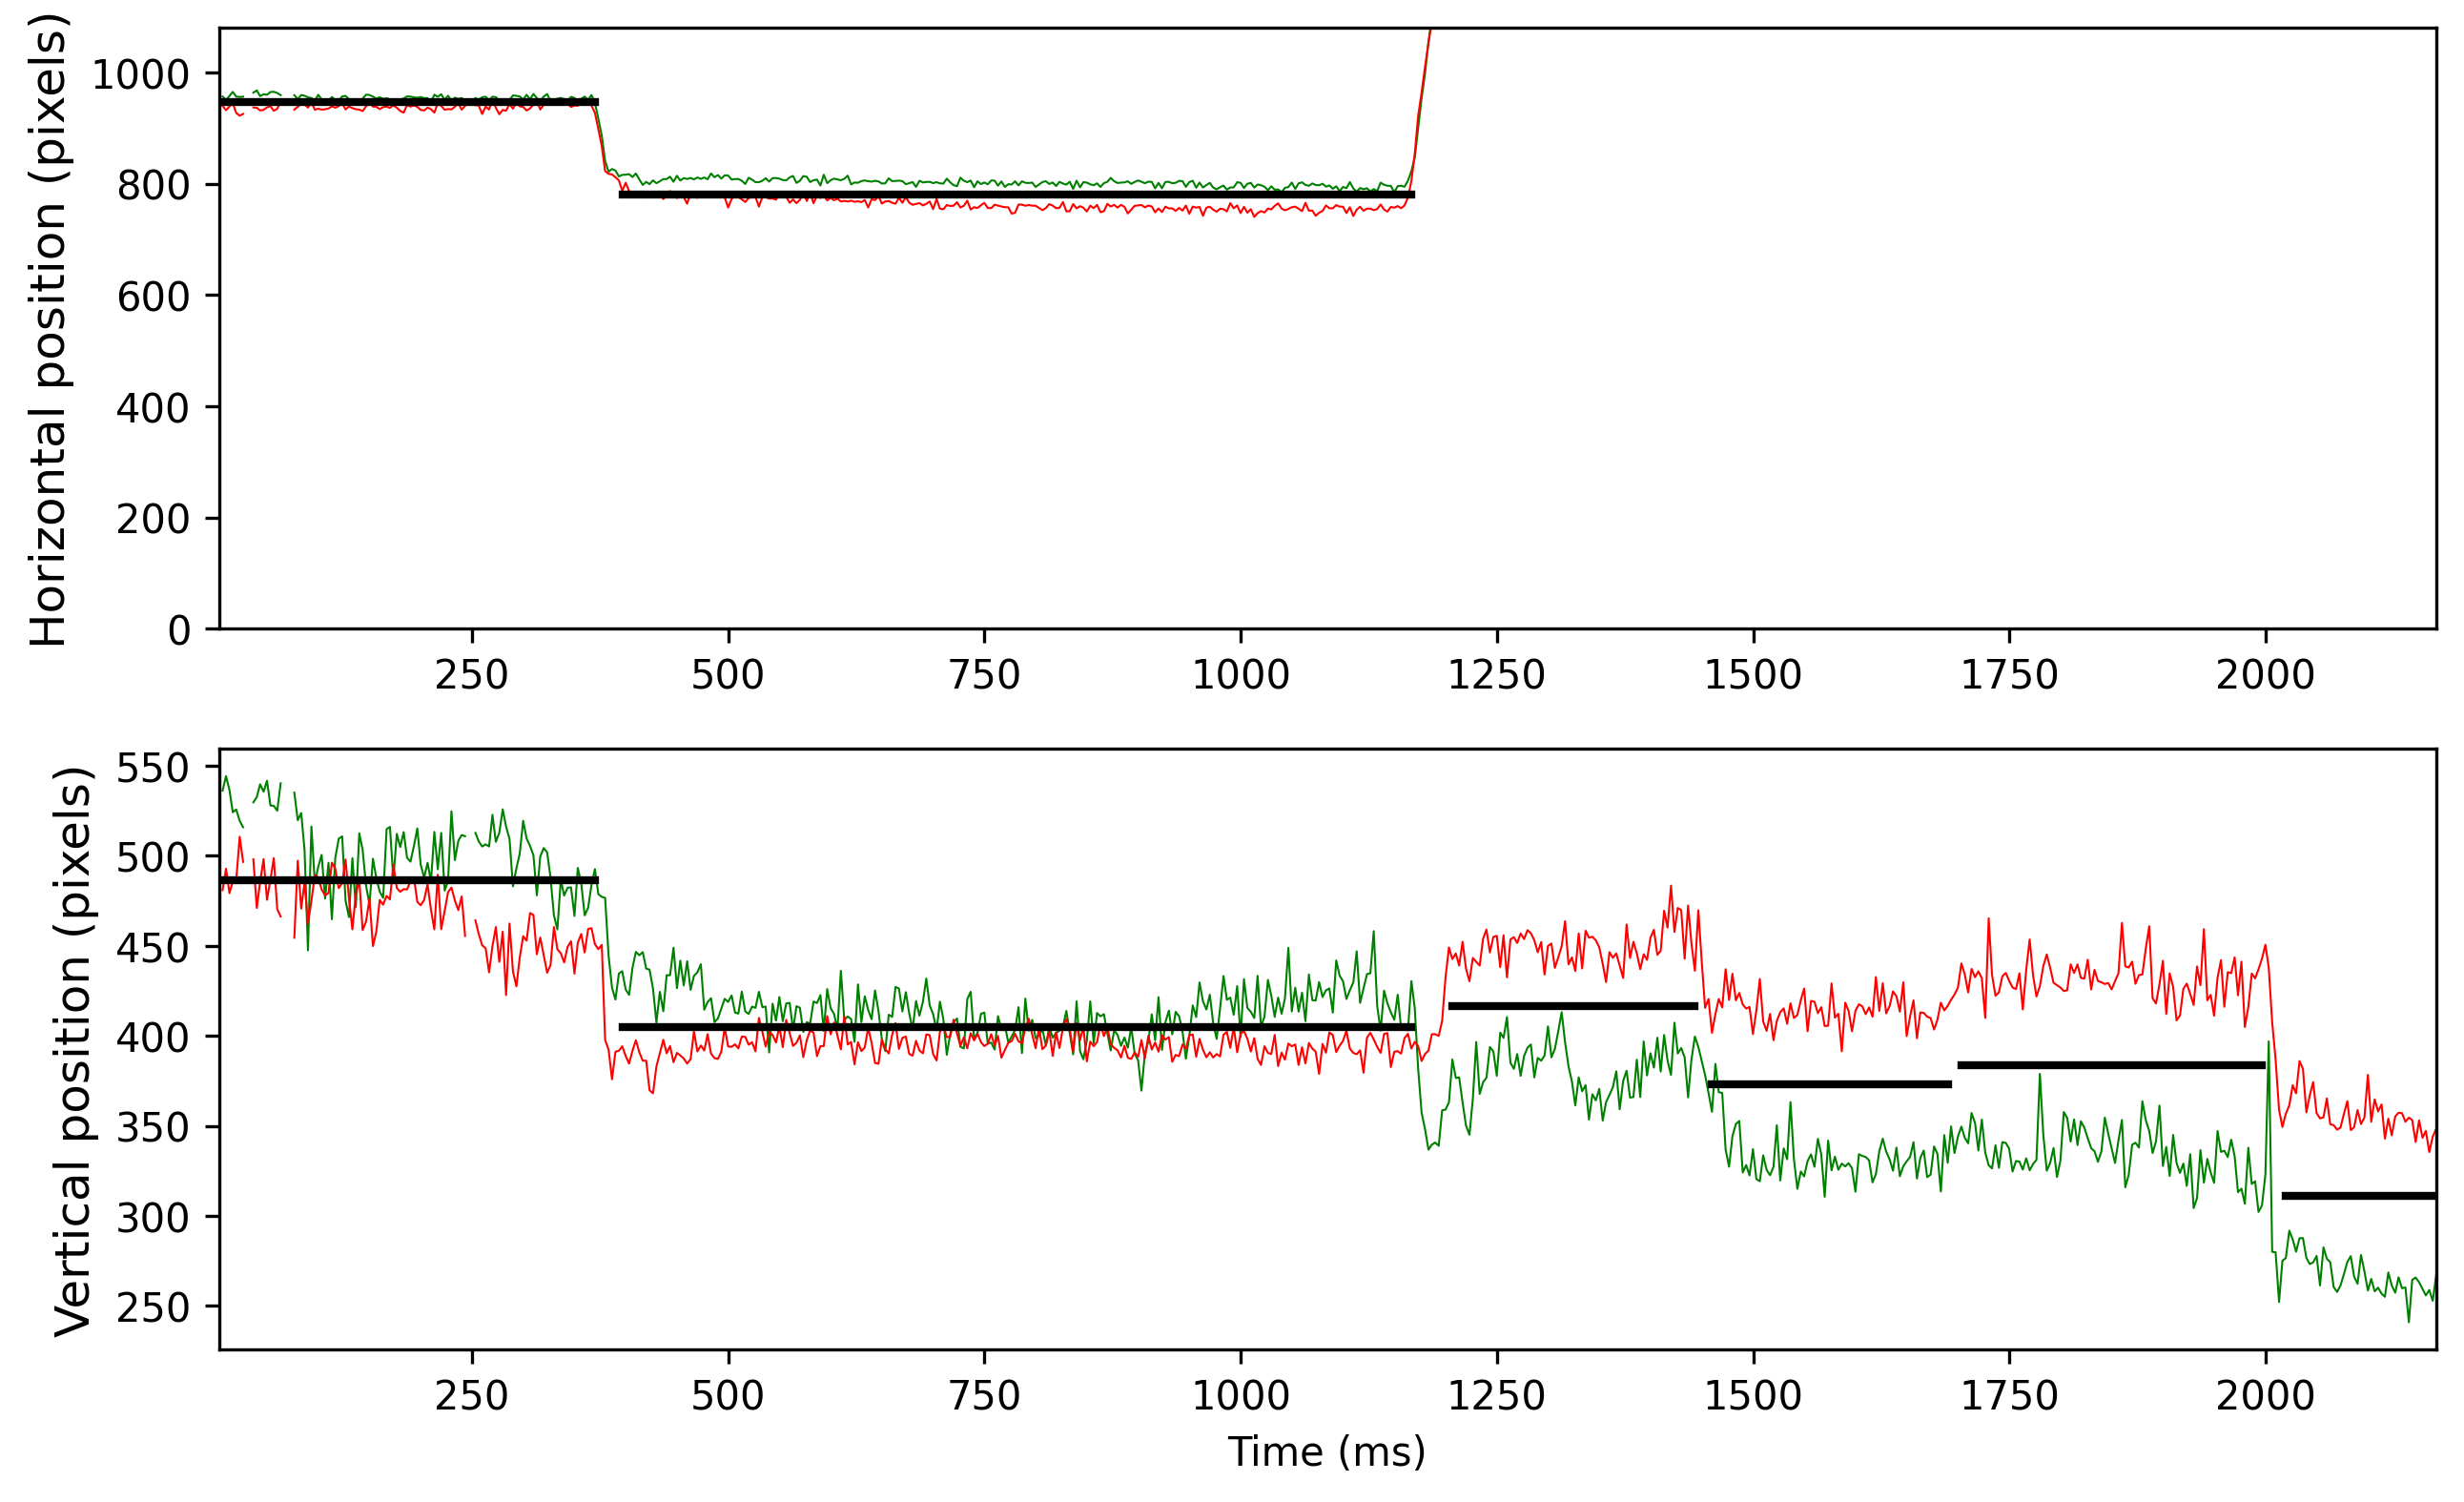

  Processing file 2 of 5
    Loading data from: ./example_data\participant1\2.tsv
    Running fixation classification...
    Saving image to: ./output\participant1\2.png
  Processing file 3 of 5
    Loading data from: ./example_data\participant1\3.tsv
    Running fixation classification...
    Saving image to: ./output\participant1\3.png
  Processing file 4 of 5
    Loading data from: ./example_data\participant1\4.tsv
    Running fixation classification...
    Saving image to: ./output\participant1\4.png
  Processing file 5 of 5
    Loading data from: ./example_data\participant1\5.tsv
    Running fixation classification...
    Saving image to: ./output\participant1\5.png
Processing folder 2 of 2
  Processing file 1 of 5
    Loading data from: ./example_data\participant2\1.tsv
    Running fixation classification...
    Saving image to: ./output\participant2\1.png
  Processing file 2 of 5
    Loading data from: ./example_data\participant2\2.tsv
    Running fixation classification...
    

In [6]:
has_show_figure = False
for folder_idx, folder in enumerate(all_folders):
    if log_level>0:
        print('Processing folder {} of {}'.format(folder_idx + 1, number_of_folders))

    # make output folder
    if do_plot_data:
        outFold = os.path.join(folders['output'], (folder.split(os.sep)[-1]))
        if not os.path.isdir(outFold):
            os.mkdir(outFold)

    if number_of_files[folder_idx] == 0:
        if log_level>0:
            print('  folder is empty, continuing to next folder')
        continue

    for file_idx, file in enumerate(all_files[folder_idx]):
        if log_level>0:
            print('  Processing file {} of {}'.format(file_idx + 1, number_of_files[folder_idx]))

        # Get current file name
        file_name = os.path.join(folder, file)
        ## IMPORT DATA
        if log_level>0:
            print('    Loading data from: {}'.format(file_name))
        data = imp.tobii_TX300(file_name, [opt['xres'], opt['yres']])

        # check whether we have data, if not, continue to next file
        if len(data['time']) == 0:
            if log_level>0:
                print('    No data found in file')
            continue

        # RUN FIXATION DETECTION
        if log_level>0:
            print('    Running fixation classification...')
        try:
            fix,_,_ = I2MC.I2MC(data,opt,log_level==2,logging_offset="      ")
        except Exception as e:
            print('    Error in file {}: {}'.format(file_name, e))
            continue

        if not fix:
            if log_level>0:
                print('    Fixation classification did not succeed with file {}'.format(file_name))
            continue

        if fix != False:
            ## PLOT RESULTS
            if do_plot_data:
                # pre-allocate name for saving file
                save_file = os.path.join(outFold, os.path.splitext(file)[0]+'.png')
                f = I2MC.plot.data_and_fixations(data, fix, fix_as_line=True, res=[opt['xres'], opt['yres']])
                # save figure and close
                if log_level>0:
                    print('    Saving image to: ' + save_file)
                f.savefig(save_file)
                if not has_show_figure:
                    plt.show()
                    has_show_figure = True
                else:
                    plt.close(f)

            # Write data to file
            fix['participant'] = folder.split(os.sep)[-1]
            fix['trial'] = os.path.splitext(file)[0]
            fix_df = pd.DataFrame(fix)
            fix_df.to_csv(fix_file, mode='a', header=not os.path.exists(fix_file),
                          na_rep='nan', sep='\t', index=False, float_format='%.3f')